# Градиентный бустинг своими руками

В этом задании будет использоваться датасет boston из sklearn.datasets. Оставьте последние 25% объектов для контроля качества, разделив X и y на X_train, y_train и X_test, y_test. Целью задания будет реализовать простой вариант градиентного бустинга над регрессионными деревьями для случая квадратичной функции потерь.

In [63]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets, model_selection, metrics, ensemble, tree, linear_model

In [37]:
%matplotlib inline

In [19]:
boston = datasets.load_boston()
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [31]:
X = boston.data
y = boston.target

n = len(boston.data)
X_train = np.array(X[:int(0.75*n)])
X_test = np.array(X[int(0.75*n):])
y_train = np.array(y[:int(0.75*n)])
y_test = np.array(y[int(0.75*n):])

### Задание 1

Как вы уже знаете из лекций, бустинг - это метод построения композиций базовых алгоритмов с помощью последовательного добавления к текущей композиции нового алгоритма с некоторым коэффициентом. Градиентный бустинг обучает каждый новый алгоритм так, чтобы он приближал антиградиент ошибки по ответам композиции на обучающей выборке. Аналогично минимизации функций методом градиентного спуска, в градиентном бустинге мы подправляем композицию, изменяя алгоритм в направлении антиградиента ошибки. Воспользуйтесь формулой из лекций, задающей ответы на обучающей выборке, на которые нужно обучать новый алгоритм (фактически это лишь чуть более подробно расписанный градиент от ошибки), и получите частный ее случай, если функция потерь L - квадрат отклонения ответа композиции a(x) от правильного ответа y на данном x.

Если вы давно не считали производную самостоятельно, вам поможет таблица производных элементарных функций (которую несложно найти в интернете) и правило дифференцирования сложной функции. После дифференцирования квадрата у вас возникнет множитель 2 — т.к. нам все равно предстоит выбирать коэффициент, с которым будет добавлен новый базовый алгоритм, проигноируйте этот множитель при дальнейшем построении алгоритма.

L'z(y,a(x)) = 2(a(x) - y)

### Задание 2

Заведите массив для объектов DecisionTreeRegressor (будем их использовать в качестве базовых алгоритмов) и для вещественных чисел (это будут коэффициенты перед базовыми алгоритмами). В цикле обучите последовательно 50 решающих деревьев с параметрами max_depth=5 и random_state=42 (остальные параметры - по умолчанию). В бустинге зачастую используются сотни и тысячи деревьев, но мы ограничимся 50, чтобы алгоритм работал быстрее, и его было проще отлаживать (т.к. цель задания разобраться, как работает метод). Каждое дерево должно обучаться на одном и том же множестве объектов, но ответы, которые учится прогнозировать дерево, будут меняться в соответствие с полученным в задании 1 правилом. Попробуйте для начала всегда брать коэффициент равным 0.9. Обычно оправдано выбирать коэффициент значительно меньшим - порядка 0.05 или 0.1, но т.к. в нашем учебном примере на стандартном датасете будет всего 50 деревьев, возьмем для начала шаг побольше.

В процессе реализации обучения вам потребуется функция, которая будет вычислять прогноз построенной на данный момент композиции деревьев на выборке X (считаем, что base_algorithms_list - список с базовыми алгоритмами, coefficients_list - список с коэффициентами перед алгоритмами)

Эта же функция поможет вам получить прогноз на контрольной выборке и оценить качество работы вашего алгоритма с помощью mean_squared_error в sklearn.metrics. Возведите результат в степень 0.5, чтобы получить RMSE. Полученное значение RMSE — ответ в пункте 2.

In [32]:
def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]

def L_deriv(y, z):
    return y - z

base_algorithms_list = [] 
coefficients_list = []

for i in range(50):
    dtree = tree.DecisionTreeRegressor(max_depth=5, random_state=42)
    if i == 0:
        dtree.fit(X_train, y_train)
    else:
        z = gbm_predict(X_train)
        dtree.fit(X_train, L_deriv(y_train, z))
    base_algorithms_list.append(dtree)
    coefficients_list.append(0.9)
    print('Model_{0} MSE = {1}'.format(i, np.sqrt(metrics.mean_squared_error(y_test, gbm_predict(X_test)))))

RMSE = np.sqrt(metrics.mean_squared_error(y_test, gbm_predict(X_test)))

with open('gboost1.txt', 'w') as f_out:
        f_out.write(str(RMSE))

Model_0 MSE = 4.258124603131531
Model_1 MSE = 4.671153714252575
Model_2 MSE = 4.902307279003964
Model_3 MSE = 4.964147618734462
Model_4 MSE = 5.20526450047539
Model_5 MSE = 5.135565602127196
Model_6 MSE = 5.240746955112687
Model_7 MSE = 5.289270262665005
Model_8 MSE = 5.474743913112658
Model_9 MSE = 5.487351059181247
Model_10 MSE = 5.493005009464344
Model_11 MSE = 5.486541185059441
Model_12 MSE = 5.485319403332965
Model_13 MSE = 5.491142418867942
Model_14 MSE = 5.4234289382521625
Model_15 MSE = 5.455189053902552
Model_16 MSE = 5.453903636946008
Model_17 MSE = 5.442535087357115
Model_18 MSE = 5.451577011033647
Model_19 MSE = 5.450957836386989
Model_20 MSE = 5.455454044759808
Model_21 MSE = 5.452830834182104
Model_22 MSE = 5.4534823020413565
Model_23 MSE = 5.456955189013637
Model_24 MSE = 5.4585969199592395
Model_25 MSE = 5.4597046298350955
Model_26 MSE = 5.458441954443328
Model_27 MSE = 5.459544166421452
Model_28 MSE = 5.474640780590228
Model_29 MSE = 5.455978129276078
Model_30 MSE = 5.

### Задание 3

Вас может также беспокоить, что при движении с постоянным шагом вблизи минимума ошибки ответы на обучающей выборке меняются слишком резко, перескакивая через минимум. Попробуйте уменьшать вес перед каждым алгоритмом с каждой следующей итерацией по формуле 0.9 / (1.0 + i), где i - номер итерации (от 0 до 49). Используйте качество работы алгоритма как ответ в пункте 3. В реальности часто применяется следующая стратегия выбора шага: как только выбран алгоритм, подберем коэффициент перед ним численным методом оптимизации таким образом, чтобы отклонение от правильных ответов было минимальным. Мы не будем предлагать вам реализовать это для выполнения задания, но рекомендуем попробовать разобраться с такой стратегией и реализовать ее при случае для себя.

In [33]:
def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]

def L_deriv(y, z):
    return y - z

base_algorithms_list = [] 
coefficients_list = []

for i in range(50):
    dtree = tree.DecisionTreeRegressor(max_depth=5, random_state=42)
    if i == 0:
        dtree.fit(X_train, y_train)
    else:
        z = gbm_predict(X_train)
        dtree.fit(X_train, L_deriv(y_train, z))
    base_algorithms_list.append(dtree)
    coefficients_list.append(0.9/(1+i))
    print('Model_{0} MSE = {1}'.format(i, np.sqrt(metrics.mean_squared_error(y_test, gbm_predict(X_test)))))

RMSE = np.sqrt(metrics.mean_squared_error(y_test, gbm_predict(X_test)))

with open('gboost1_ass2.txt', 'w') as f_out:
        f_out.write(str(RMSE))

Model_0 MSE = 4.258124603131531
Model_1 MSE = 4.411594948336074
Model_2 MSE = 4.391183171661546
Model_3 MSE = 4.458775073285299
Model_4 MSE = 4.498661031729782
Model_5 MSE = 4.5168152101676124
Model_6 MSE = 4.550526944390747
Model_7 MSE = 4.609092468715132
Model_8 MSE = 4.6339875745933385
Model_9 MSE = 4.651558505714779
Model_10 MSE = 4.659211687810463
Model_11 MSE = 4.665846192244087
Model_12 MSE = 4.687756339977889
Model_13 MSE = 4.705212386904845
Model_14 MSE = 4.70888638920925
Model_15 MSE = 4.727160820532567
Model_16 MSE = 4.738601041184404
Model_17 MSE = 4.7434294144854805
Model_18 MSE = 4.747957771408691
Model_19 MSE = 4.754535803819599
Model_20 MSE = 4.760702807935853
Model_21 MSE = 4.76469042919606
Model_22 MSE = 4.764828870587975
Model_23 MSE = 4.763080541850576
Model_24 MSE = 4.763091173078234
Model_25 MSE = 4.762268473295419
Model_26 MSE = 4.758055256544697
Model_27 MSE = 4.768499657813316
Model_28 MSE = 4.7718046637409675
Model_29 MSE = 4.780389023483234
Model_30 MSE = 4.7

Обратите внимание, что более аккуратный выбор шага позволил понизить RMSE на тестовой выборке (если нет - попробуйте перезапустить алгоритм несколько раз - в среднем качество должно было улучшиться). Однако не стоит относиться к этому результату слишком доверчиво - небольшие изменения в формуле вычисления величины шага могут легко "сломать" этот эффект. Выбор хорошего шага в градиентном спуске всегда достаточно непростой вопрос - остается только порадоваться, что почти всегда можно использовать готовые реализации из библиотек.

### Задание 4

Реализованный вами метод - градиентный бустинг над деревьями - очень популярен в машинном обучении. Он представлен как в самой библиотеке sklearn, так и в сторонней библиотеке XGBoost, которая имеет свой питоновский интерфейс. На практике XGBoost работает заметно лучше GradientBoostingRegressor из sklearn, но для этого задания вы можете использовать любую реализацию. Исследуйте, переобучается ли градиентный бустинг с ростом числа итераций (и подумайте, почему), а также с ростом глубины деревьев. На основе наблюдений выпишите через пробел номера правильных из приведенных ниже утверждений в порядке возрастания номера (это будет ответ в п.4):  
1) С увеличением числа деревьев, начиная с некоторого момента, качество работы градиентного бустинга не меняется существенно.  
2) С увеличением числа деревьев, начиная с некоторого момента, градиентный бустинг начинает переобучаться. **YES**   
3) С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга на тестовой выборке начинает ухудшаться.  **YES**  
4) С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга перестает существенно изменяться  

In [60]:
n_iter = np.arange(1,501,10)

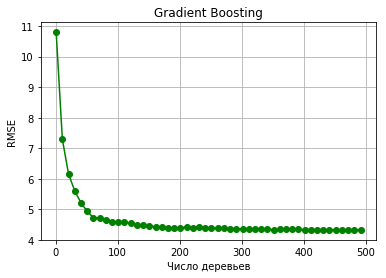

In [61]:
scores = []
for n in n_iter:
    gbr = ensemble.GradientBoostingRegressor(n_estimators=n, random_state=1)
    gbr.fit(X_train, y_train)
    scores.append(np.sqrt(metrics.mean_squared_error(y_test, gbr.predict(X_test))))

plt.title('Gradient Boosting')
plt.grid(True)
plt.plot(n_iter, scores, 'g-', marker='o')
plt.xlabel('Число деревьев')
plt.ylabel('RMSE')
plt.show()

In [55]:
depths = np.arange(1,30,1)

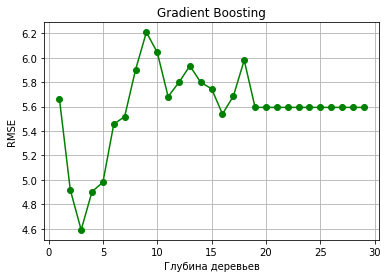

In [56]:
scores = []
for d in depths:
    gbr = ensemble.GradientBoostingRegressor(max_depth=d, random_state=1)
    gbr.fit(X_train, y_train)
    scores.append(np.sqrt(metrics.mean_squared_error(y_test, gbr.predict(X_test))))

plt.title('Gradient Boosting')
plt.grid(True)
plt.plot(depths, scores, 'g-', marker='o')
plt.xlabel('Глубина деревьев')
plt.ylabel('RMSE')
plt.show()

In [62]:
with open('gboost1_ass3.txt', 'w') as f_out:
        f_out.write('2 3')

В самом деле, градиентный бустинг все больше подгоняется под данные с ростом числа деревьев, а рост глубины деревьев только ускоряет этот процесс. Начиная с некоторого момента алгоритм будет все больше переобучаться.

### Задание 5

Сравните получаемое с помощью градиентного бустинга качество с качеством работы линейной регрессии. Для этого обучите LinearRegression из sklearn.linear_model (с параметрами по умолчанию) на обучающей выборке и оцените для прогнозов полученного алгоритма на тестовой выборке RMSE. Полученное качество - ответ в пункте 5. В данном примере качество работы простой модели должно было оказаться хуже, но не стоит забывать, что так бывает не всегда. В заданиях к этому курсу вы еще встретите пример обратной ситуации.

In [64]:
lnr = linear_model.LinearRegression()
lnr.fit(X_train, y_train)
RMSE = np.sqrt(metrics.mean_squared_error(y_test, lnr.predict(X_test)))

with open('gboost1_ass4.txt', 'w') as f_out:
        f_out.write(str(RMSE))

Качество работы простого метода (линейной регрессии) оказалось хуже. Этот результат в некоторой степени завораживает: всего 1 деревьев, каждое из которых в каждом своем листе оценивает целевую зависимость некоторой константой, уже решили задачу регрессии лучше, чем линейная модель.